# Progetto Laboratorio di Ottimizzazione, Intelligenza Artificiale e Machine Learning
A cura di Alessandro Cacchi 
- Email istituzionale: alessandro.cacchi@studio.unibo.it
- Matricola: 001080687

Sviluppo di una architettura di rete neurale volta a risolvere una classificazione multi-classe.


# Inclusione delle librerie necessarie

In [98]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import Counter
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import WeightedRandomSampler


In [99]:
# Carica il file delle etichette
labels = pd.read_csv("archive 2/train_labels.csv")

# Identifica i record con width o height pari a zero
invalid_rows = labels[(labels['width'] == 0) | (labels['height'] == 0)]
print(f"Righe con larghezza o altezza zero:\n{invalid_rows}")


Righe con larghezza o altezza zero:
Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []


In [100]:
print(labels.head())  # Stampa le prime righe per vedere la struttura

   filename  width  height              class  xmin  ymin  xmax  ymax
0    35.jpg    750    1200      ace of hearts   149   328   603   978
1   d38.jpg    183     275  three of diamonds    38    58   143   220
2    85.jpg    281     470     jack of hearts    14    49   265   402
3   s75.png    204     247    seven of spades    17    13   171   231
4  C710.jpg    183     275     seven of seven    12    19   170   258


In [101]:
class CardDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform

        # Creazione di un dizionario di mapping per le classi
        class_names = self.labels['class'].unique()
        self.class_to_idx = {name: idx for idx, name in enumerate(class_names)}
        self.idx_to_class = {idx: name for name, idx in self.class_to_idx.items()}
        self.labels['class'] = self.labels['class'].map(self.class_to_idx)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        img_path = os.path.join(self.images_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")

        bbox = torch.tensor([
            row['xmin'] / row['width'],
            row['ymin'] / row['height'],
            row['xmax'] / row['width'],
            row['ymax'] / row['height']
        ], dtype=torch.float)

        label = row['class']
        
        # Debug: stampa informazioni sull'immagine e sull'etichetta
        print(f"Immagine: {row['filename']}, Etichetta numerica: {label}, Classe: {self.idx_to_class[label]}")

        if self.transform:
            image = self.transform(image)
        return image, bbox, label

    def get_idx_to_class(self):
        return self.idx_to_class


In [102]:
# Istanzia il dataset
train_dataset = CardDataset(images_dir='archive 2/train/train', labels_file='archive 2/train_labels.csv', transform=None)

# Carica alcune immagini e verifica le etichette
for i in range(5):  # Mostra 5 esempi
    image, bbox, label = train_dataset[i]
    print(f"Indice: {i}, Etichetta numerica: {label}, Classe: {train_dataset.get_idx_to_class()[label]}")


Immagine: 35.jpg, Etichetta numerica: 0, Classe: ace of hearts
Indice: 0, Etichetta numerica: 0, Classe: ace of hearts
Immagine: d38.jpg, Etichetta numerica: 1, Classe: three of diamonds
Indice: 1, Etichetta numerica: 1, Classe: three of diamonds
Immagine: 85.jpg, Etichetta numerica: 2, Classe: jack of hearts
Indice: 2, Etichetta numerica: 2, Classe: jack of hearts
Immagine: s75.png, Etichetta numerica: 3, Classe: seven of spades
Indice: 3, Etichetta numerica: 3, Classe: seven of spades
Immagine: C710.jpg, Etichetta numerica: 4, Classe: seven of seven
Indice: 4, Etichetta numerica: 4, Classe: seven of seven


In [103]:
def collate_fn(batch):
    # Filtra gli elementi None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:  # Nessun elemento valido
        return None
    images, bboxes, labels = zip(*batch)
    
    # Verifica i batch
    print(f"Batch - Immagini: {len(images)}, Bboxes: {len(bboxes)}, Etichette: {len(labels)}")
    
    return torch.stack(images, 0), torch.stack(bboxes, 0), torch.tensor(labels)


# Definizione del dataset personalizzato

In [104]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [105]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [106]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [107]:
# Configura il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Funzione di perdita bilanciata
criterion = FocalLoss()

# Inizializza i modelli
num_classes = 52
resnet_model = ResNet50Model(num_classes=num_classes).to(device)
efficientnet_model = EfficientNetModel(num_classes=num_classes).to(device)

# Ottimizzatori
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)


# Trasformazioni per le immagini

In [108]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Dataset e DataLoader

In [109]:
# Percorsi per immagini ed etichette
train_images_dir = "archive 2/train/train"
train_labels_file = "archive 2/train_labels.csv"
test_images_dir = "archive 2/test/test"
test_labels_file = "archive 2/test_labels.csv"

# Dataset
train_dataset = CardDataset(images_dir=train_images_dir, labels_file=train_labels_file, transform=train_transform)
test_dataset = CardDataset(images_dir=test_images_dir, labels_file=test_labels_file, transform=test_transform)

# Calcolo dei pesi per classe
train_class_counts = train_dataset.labels['class'].value_counts().sort_index()
class_weights = 1.0 / train_class_counts
sample_weights = [class_weights[label] for label in train_dataset.labels['class']]

# Sampler bilanciato
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [110]:
# Debug: verifica coerenza di class_to_idx e idx_to_class
print("Class to Index Mapping:", train_dataset.class_to_idx)
print("Index to Class Mapping:", train_dataset.get_idx_to_class())

# Debug: visualizza alcune righe del file delle etichette
print("Prime righe del file delle etichette:")
print(pd.read_csv("archive 2/train_labels.csv").head())


Class to Index Mapping: {'ace of hearts': 0, 'three of diamonds': 1, 'jack of hearts': 2, 'seven of spades': 3, 'seven of seven': 4, 'queen of spades': 5, 'three of hearts': 6, 'queen of clubs': 7, 'king of diamonds': 8, 'ace of spades': 9, 'ten of hearts': 10, 'three of spades': 11, 'four of spades': 12, 'six of spades': 13, 'seven of hearts': 14, 'five of spades': 15, 'four of clubs': 16, 'nine of spades': 17, 'ten of clubs': 18, 'six of diamonds': 19, 'nine of diamonds': 20, 'two of hearts': 21, 'jack of clubs': 22, 'ten of diamonds': 23, 'nine of clubs': 24, 'nine of hearts': 25, 'ace of diamonds': 26, 'two of clubs': 27, 'five of diamonds': 28, 'king of clubs': 29, 'queen of diamonds': 30, 'eight of hearts': 31, 'two of diamonds': 32, 'six of hearts': 33, 'eigth of clubs': 34, 'eight of spades': 35, 'four of hearts': 36, 'king of hearts': 37, 'two of spades': 38, 'five of clubs': 39, 'jack of spades': 40, 'three of clubs': 41, 'ten of spades': 42, 'five of hearts': 43, 'jack of di

# Analisi del Dataset

In [111]:
def analyze_dataset(dataset):
    # Conta le occorrenze delle classi
    class_counts = Counter()
    for _, _, labels in dataset:
        class_counts.update([labels])  # Converte l'intero in una lista con un elemento

    # Visualizza la distribuzione
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Classi")
    plt.ylabel("Numero di Occorrenze")
    plt.title("Distribuzione delle Classi nel Dataset")
    plt.xticks(classes, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Stampa le classi con il numero di occorrenze
    print("Distribuzione delle classi:")
    for cls, count in class_counts.items():
        print(f"Classe {cls}: {count} esempi")
    
    return class_counts

_Analisi del dataset di addestramento_

Analisi del dataset di addestramento:
Immagine: 35.jpg, Etichetta numerica: 0, Classe: ace of hearts
Immagine: d38.jpg, Etichetta numerica: 1, Classe: three of diamonds
Immagine: 85.jpg, Etichetta numerica: 2, Classe: jack of hearts
Immagine: s75.png, Etichetta numerica: 3, Classe: seven of spades
Immagine: C710.jpg, Etichetta numerica: 4, Classe: seven of seven
Immagine: qrgji.png, Etichetta numerica: 5, Classe: queen of spades
Immagine: H35.jpg, Etichetta numerica: 6, Classe: three of hearts
Immagine: q29.png, Etichetta numerica: 7, Classe: queen of clubs
Immagine: k22.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: 6.jpg, Etichetta numerica: 9, Classe: ace of spades
Immagine: H102.png, Etichetta numerica: 10, Classe: ten of hearts
Immagine: s34.jpg, Etichetta numerica: 11, Classe: three of spades
Immagine: q7.jpg, Etichetta numerica: 7, Classe: queen of clubs
Immagine: s47.jpg, Etichetta numerica: 12, Classe: four of spades
Immagine: s62.jpg, Etichetta numerica: 13, C

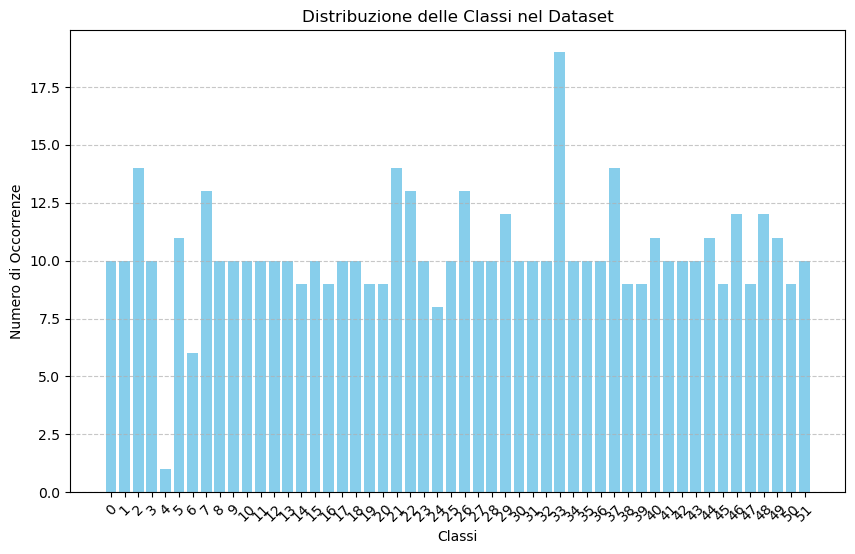

Distribuzione delle classi:
Classe 0: 10 esempi
Classe 1: 10 esempi
Classe 2: 14 esempi
Classe 3: 10 esempi
Classe 4: 1 esempi
Classe 5: 11 esempi
Classe 6: 6 esempi
Classe 7: 13 esempi
Classe 8: 10 esempi
Classe 9: 10 esempi
Classe 10: 10 esempi
Classe 11: 10 esempi
Classe 12: 10 esempi
Classe 13: 10 esempi
Classe 14: 9 esempi
Classe 15: 10 esempi
Classe 16: 9 esempi
Classe 17: 10 esempi
Classe 18: 10 esempi
Classe 19: 9 esempi
Classe 20: 9 esempi
Classe 21: 14 esempi
Classe 22: 13 esempi
Classe 23: 10 esempi
Classe 24: 8 esempi
Classe 25: 10 esempi
Classe 26: 13 esempi
Classe 27: 10 esempi
Classe 28: 10 esempi
Classe 29: 12 esempi
Classe 30: 10 esempi
Classe 31: 10 esempi
Classe 32: 10 esempi
Classe 33: 19 esempi
Classe 34: 10 esempi
Classe 35: 10 esempi
Classe 36: 10 esempi
Classe 37: 14 esempi
Classe 38: 9 esempi
Classe 39: 9 esempi
Classe 40: 11 esempi
Classe 41: 10 esempi
Classe 42: 10 esempi
Classe 43: 10 esempi
Classe 44: 11 esempi
Classe 45: 9 esempi
Classe 46: 12 esempi
Class

In [112]:
# Analisi del dataset di addestramento
print("Analisi del dataset di addestramento:")
train_class_counts = analyze_dataset(train_dataset)

_Analisi del dataset di test_

Analisi del dataset di test:
Immagine: H710.jpg, Etichetta numerica: 0, Classe: seven of hearts
Immagine: C311.jpg, Etichetta numerica: 1, Classe: three of clubs
Immagine: s611.jpg, Etichetta numerica: 2, Classe: six of spades
Immagine: H811.jpg, Etichetta numerica: 3, Classe: eight of hearts
Immagine: ace-of-diamonds-vintage-playing-card-isolated-on-white-clipping-path-included-2AYKBH0.jpg, Etichetta numerica: 4, Classe: ace of diamonds
Immagine: H1012.png, Etichetta numerica: 5, Classe: ten of hearts
Immagine: king-spades-casino-card-game-P9N5YE.jpg, Etichetta numerica: 6, Classe: king of spades
Immagine: d213.png, Etichetta numerica: 7, Classe: two of diamonds
Immagine: 32199889600_2a7a32e987_b.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: H211.jpg, Etichetta numerica: 9, Classe: two of hearts
Immagine: download.jpeg, Etichetta numerica: 10, Classe: jack of spades
Immagine: C713.png, Etichetta numerica: 11, Classe: six of clubs
Immagine: C910.png, Etichetta numerica

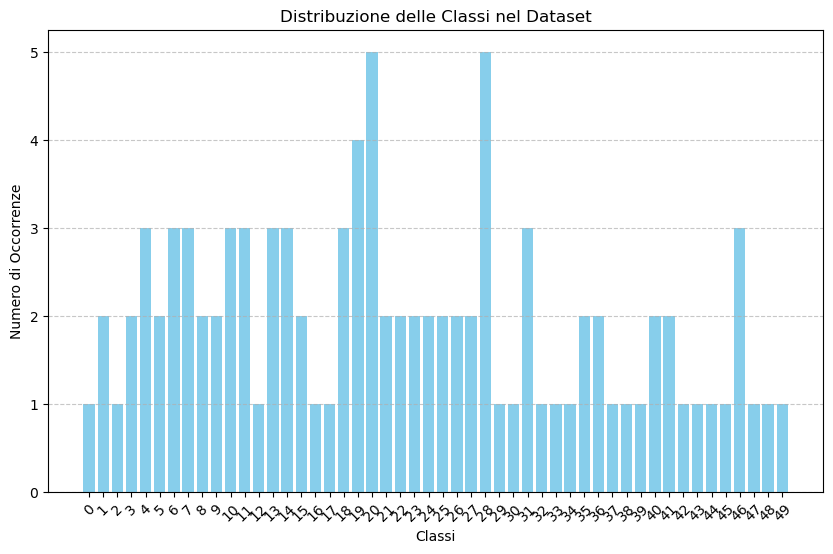

Distribuzione delle classi:
Classe 0: 1 esempi
Classe 1: 2 esempi
Classe 2: 1 esempi
Classe 3: 2 esempi
Classe 4: 3 esempi
Classe 5: 2 esempi
Classe 6: 3 esempi
Classe 7: 3 esempi
Classe 8: 2 esempi
Classe 9: 2 esempi
Classe 10: 3 esempi
Classe 11: 3 esempi
Classe 12: 1 esempi
Classe 13: 3 esempi
Classe 14: 3 esempi
Classe 15: 2 esempi
Classe 16: 1 esempi
Classe 17: 1 esempi
Classe 18: 3 esempi
Classe 19: 4 esempi
Classe 20: 5 esempi
Classe 21: 2 esempi
Classe 22: 2 esempi
Classe 23: 2 esempi
Classe 24: 2 esempi
Classe 25: 2 esempi
Classe 26: 2 esempi
Classe 27: 2 esempi
Classe 28: 5 esempi
Classe 29: 1 esempi
Classe 30: 1 esempi
Classe 31: 3 esempi
Classe 32: 1 esempi
Classe 33: 1 esempi
Classe 34: 1 esempi
Classe 35: 2 esempi
Classe 36: 2 esempi
Classe 37: 1 esempi
Classe 38: 1 esempi
Classe 39: 1 esempi
Classe 40: 2 esempi
Classe 41: 2 esempi
Classe 42: 1 esempi
Classe 43: 1 esempi
Classe 44: 1 esempi
Classe 45: 1 esempi
Classe 46: 3 esempi
Classe 47: 1 esempi
Classe 48: 1 esempi
Cl

In [113]:
# Se desideri, analizza anche il dataset di test
print("Analisi del dataset di test:")
test_class_counts = analyze_dataset(test_dataset)

In [114]:
# Verifica la struttura di un batch
for images, bboxes, labels in train_loader:
    print(f"Batch - Immagini: {images.shape}, Bboxes: {bboxes.shape}, Etichette: {labels.shape}")
    break  # Stampa solo il primo batch


Immagine: H96.jpg, Etichetta numerica: 25, Classe: nine of hearts
Immagine: 21.jpg, Etichetta numerica: 9, Classe: ace of spades
Immagine: C105.jpg, Etichetta numerica: 18, Classe: ten of clubs
Immagine: q14.jpg, Etichetta numerica: 30, Classe: queen of diamonds
Immagine: H85.jpg, Etichetta numerica: 31, Classe: eight of hearts
Immagine: d65.jpg, Etichetta numerica: 19, Classe: six of diamonds
Immagine: H39.jpg, Etichetta numerica: 21, Classe: two of hearts
Immagine: k35.jpg, Etichetta numerica: 37, Classe: king of hearts
Immagine: 51.png, Etichetta numerica: 2, Classe: jack of hearts
Immagine: C59.jpg, Etichetta numerica: 39, Classe: five of clubs
Immagine: C92.png, Etichetta numerica: 24, Classe: nine of clubs
Immagine: C108.jpg, Etichetta numerica: 18, Classe: ten of clubs
Immagine: C24.jpg, Etichetta numerica: 27, Classe: two of clubs
Immagine: C44.jpg, Etichetta numerica: 16, Classe: four of clubs
Immagine: q21.jpg, Etichetta numerica: 48, Classe: queen of hearts
Immagine: s72.jpg

# Ciclo di addestramento

In [115]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    history = {"loss": [], "accuracy": []}
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, bboxes, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        history["loss"].append(running_loss / len(train_loader))
        history["accuracy"].append(train_accuracy)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")
    
    return history


In [116]:
print("Training ResNet50...")
resnet_history = train_model(resnet_model, train_loader, criterion, resnet_optimizer, epochs=5)

Training ResNet50...
Immagine: qgrdr.png, Etichetta numerica: 5, Classe: queen of spades
Immagine: C56.jpg, Etichetta numerica: 39, Classe: five of clubs
Immagine: d43.jpg, Etichetta numerica: 50, Classe: four of diamonds
Immagine: C102.jpg, Etichetta numerica: 18, Classe: ten of clubs
Immagine: d62.jpg, Etichetta numerica: 19, Classe: six of diamonds
Immagine: 70.jpg, Etichetta numerica: 40, Classe: jack of spades
Immagine: 14.jpg, Etichetta numerica: 46, Classe: ace of clubs
Immagine: C104.jpg, Etichetta numerica: 18, Classe: ten of clubs
Immagine: C31.jpg, Etichetta numerica: 41, Classe: three of clubs
Immagine: s39.jpg, Etichetta numerica: 11, Classe: three of spades
Immagine: d27.jpg, Etichetta numerica: 32, Classe: two of diamonds
Immagine: H25.png, Etichetta numerica: 21, Classe: two of hearts
Immagine: H510.jpg, Etichetta numerica: 43, Classe: five of hearts
Immagine: H41.jpg, Etichetta numerica: 36, Classe: four of hearts
Immagine: d81.jpg, Etichetta numerica: 51, Classe: eigh

In [117]:
print("Training EfficientNet...")
efficientnet_history = train_model(efficientnet_model, train_loader, criterion, efficientnet_optimizer, epochs=5)

Training EfficientNet...
Immagine: C26.jpg, Etichetta numerica: 27, Classe: two of clubs
Immagine: d67.jpg, Etichetta numerica: 19, Classe: six of diamonds
Immagine: d62.jpg, Etichetta numerica: 19, Classe: six of diamonds
Immagine: s84.jpg, Etichetta numerica: 35, Classe: eight of spades
Immagine: k2.jpg, Etichetta numerica: 49, Classe: king of spades
Immagine: H71.jpg, Etichetta numerica: 14, Classe: seven of hearts
Immagine: s97.jpg, Etichetta numerica: 17, Classe: nine of spades
Immagine: d98.jpg, Etichetta numerica: 20, Classe: nine of diamonds
Immagine: 36.jpg, Etichetta numerica: 0, Classe: ace of hearts
Immagine: k18.jpeg, Etichetta numerica: 37, Classe: king of hearts
Immagine: q23.jpg, Etichetta numerica: 5, Classe: queen of spades
Immagine: d102.jpg, Etichetta numerica: 23, Classe: ten of diamonds
Immagine: 95.jpg, Etichetta numerica: 2, Classe: jack of hearts
Immagine: C79.png, Etichetta numerica: 45, Classe: seven of clubs
Immagine: 18.jpg, Etichetta numerica: 46, Classe: 

In [118]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_with_metrics(model, test_loader, idx_to_class):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, _, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Converti indici in nomi di classe
    all_labels_named = [idx_to_class[label] for label in all_labels]
    all_preds_named = [idx_to_class[pred] for pred in all_preds]

    # Matrice di confusione
    cm = confusion_matrix(all_labels_named, all_preds_named, labels=list(idx_to_class.values()))
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(idx_to_class.values()), yticklabels=list(idx_to_class.values()))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Evaluating ResNet18...
Immagine: H710.jpg, Etichetta numerica: 0, Classe: seven of hearts
Immagine: C311.jpg, Etichetta numerica: 1, Classe: three of clubs
Immagine: s611.jpg, Etichetta numerica: 2, Classe: six of spades
Immagine: H811.jpg, Etichetta numerica: 3, Classe: eight of hearts
Immagine: ace-of-diamonds-vintage-playing-card-isolated-on-white-clipping-path-included-2AYKBH0.jpg, Etichetta numerica: 4, Classe: ace of diamonds
Immagine: H1012.png, Etichetta numerica: 5, Classe: ten of hearts
Immagine: king-spades-casino-card-game-P9N5YE.jpg, Etichetta numerica: 6, Classe: king of spades
Immagine: d213.png, Etichetta numerica: 7, Classe: two of diamonds
Immagine: 32199889600_2a7a32e987_b.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: H211.jpg, Etichetta numerica: 9, Classe: two of hearts
Immagine: download.jpeg, Etichetta numerica: 10, Classe: jack of spades
Immagine: C713.png, Etichetta numerica: 11, Classe: six of clubs
Immagine: C910.png, Etichetta numerica: 12, 

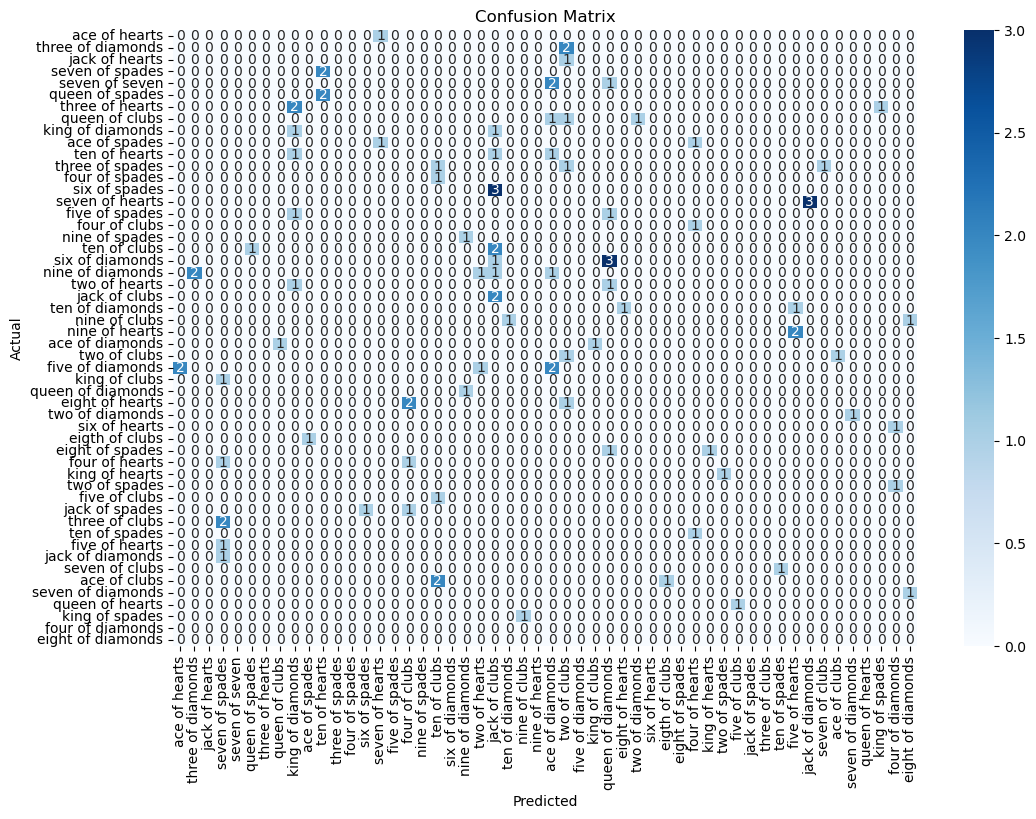

Evaluating AlexNet...
Immagine: H710.jpg, Etichetta numerica: 0, Classe: seven of hearts
Immagine: C311.jpg, Etichetta numerica: 1, Classe: three of clubs
Immagine: s611.jpg, Etichetta numerica: 2, Classe: six of spades
Immagine: H811.jpg, Etichetta numerica: 3, Classe: eight of hearts
Immagine: ace-of-diamonds-vintage-playing-card-isolated-on-white-clipping-path-included-2AYKBH0.jpg, Etichetta numerica: 4, Classe: ace of diamonds
Immagine: H1012.png, Etichetta numerica: 5, Classe: ten of hearts
Immagine: king-spades-casino-card-game-P9N5YE.jpg, Etichetta numerica: 6, Classe: king of spades
Immagine: d213.png, Etichetta numerica: 7, Classe: two of diamonds
Immagine: 32199889600_2a7a32e987_b.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: H211.jpg, Etichetta numerica: 9, Classe: two of hearts
Immagine: download.jpeg, Etichetta numerica: 10, Classe: jack of spades
Immagine: C713.png, Etichetta numerica: 11, Classe: six of clubs
Immagine: C910.png, Etichetta numerica: 12, C

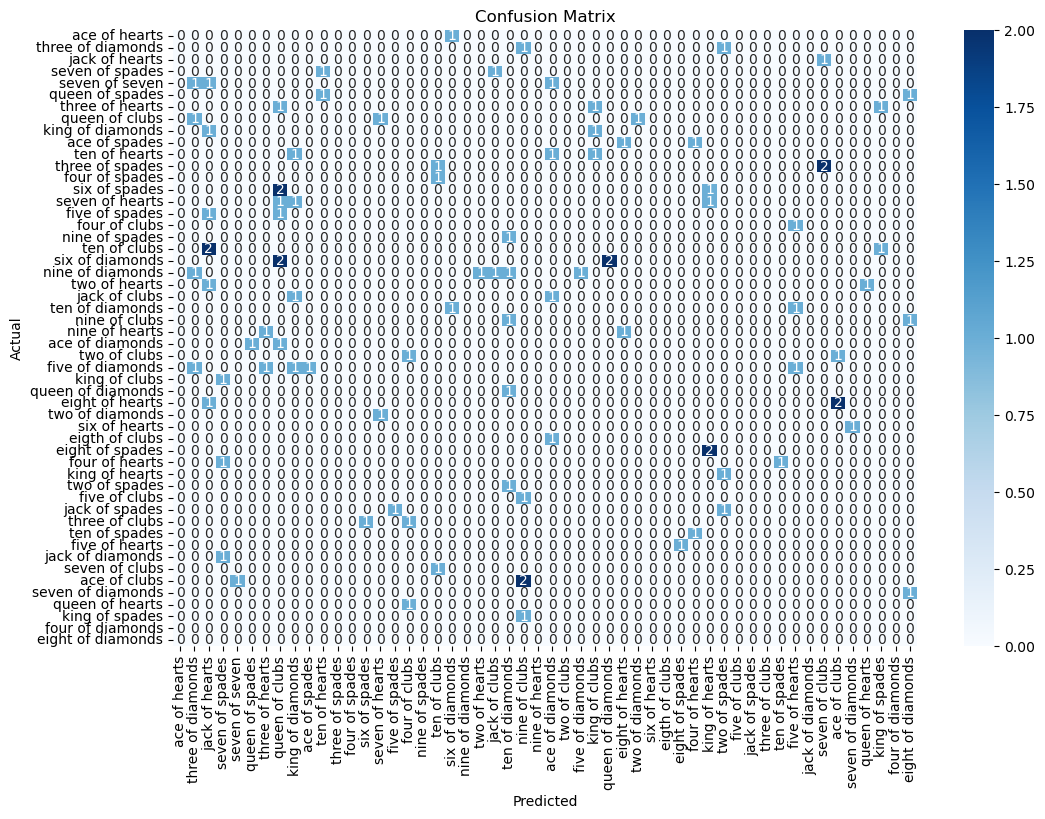

In [119]:
print("Evaluating ResNet18...")
evaluate_with_metrics(resnet_model, test_loader, train_dataset.get_idx_to_class())

print("Evaluating AlexNet...")
evaluate_with_metrics(efficientnet_model, test_loader, train_dataset.get_idx_to_class())

In [120]:
def visualize_predictions(model, test_loader, idx_to_class, num_images=4):
    model.eval()  # Imposta il modello in modalità valutazione
    images_shown = 0

    with torch.no_grad():
        for images, _, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Debug: stampa predizioni ed etichette numeriche
            print("Predizioni numeriche:", preds.cpu().numpy())
            print("Etichette reali numeriche:", labels.cpu().numpy())
            print("Predizioni testuali:", [idx_to_class[p.item()] for p in preds])
            print("Etichette testuali:", [idx_to_class[l.item()] for l in labels])

            # Converti tensori in CPU per la visualizzazione
            images = images.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            # Visualizza solo il numero richiesto di immagini
            plt.figure(figsize=(12, 12))
            for i in range(min(num_images, len(images))):
                ax = plt.subplot(1, num_images, i + 1)
                image = images[i].permute(1, 2, 0)  # Cambia ordine per visualizzazione (H, W, C)
                image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # De-normalizza
                image = torch.clamp(image, 0, 1)  # Clamping per evitare valori fuori dal range

                plt.imshow(image.numpy())
                
                # Ottieni le etichette leggibili
                true_label = idx_to_class[labels[i].item()]
                pred_label = idx_to_class[preds[i].item()]
                
                # Colore del titolo basato sulla correttezza
                color = "green" if true_label == pred_label else "red"
                plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
                plt.axis("off")
            
            plt.show()
            images_shown += min(num_images, len(images))
            if images_shown >= num_images:
                break


In [121]:
# Ottieni il dizionario idx_to_class dal dataset
train_idx_to_class = train_dataset.get_idx_to_class()


In [122]:
print("Mapping indice->classe:", train_idx_to_class)


Mapping indice->classe: {0: 'ace of hearts', 1: 'three of diamonds', 2: 'jack of hearts', 3: 'seven of spades', 4: 'seven of seven', 5: 'queen of spades', 6: 'three of hearts', 7: 'queen of clubs', 8: 'king of diamonds', 9: 'ace of spades', 10: 'ten of hearts', 11: 'three of spades', 12: 'four of spades', 13: 'six of spades', 14: 'seven of hearts', 15: 'five of spades', 16: 'four of clubs', 17: 'nine of spades', 18: 'ten of clubs', 19: 'six of diamonds', 20: 'nine of diamonds', 21: 'two of hearts', 22: 'jack of clubs', 23: 'ten of diamonds', 24: 'nine of clubs', 25: 'nine of hearts', 26: 'ace of diamonds', 27: 'two of clubs', 28: 'five of diamonds', 29: 'king of clubs', 30: 'queen of diamonds', 31: 'eight of hearts', 32: 'two of diamonds', 33: 'six of hearts', 34: 'eigth of clubs', 35: 'eight of spades', 36: 'four of hearts', 37: 'king of hearts', 38: 'two of spades', 39: 'five of clubs', 40: 'jack of spades', 41: 'three of clubs', 42: 'ten of spades', 43: 'five of hearts', 44: 'jack o

Immagine: H94.png, Etichetta numerica: 25, Classe: nine of hearts
Immagine: d98.jpg, Etichetta numerica: 20, Classe: nine of diamonds
Immagine: 7.jpg, Etichetta numerica: 9, Classe: ace of spades
Immagine: s96.jpg, Etichetta numerica: 17, Classe: nine of spades
Immagine: s92.jpg, Etichetta numerica: 17, Classe: nine of spades
Immagine: C23.jpg, Etichetta numerica: 27, Classe: two of clubs
Immagine: H35.jpg, Etichetta numerica: 6, Classe: three of hearts
Immagine: d55.jpg, Etichetta numerica: 28, Classe: five of diamonds
Immagine: d81.jpg, Etichetta numerica: 51, Classe: eight of diamonds
Immagine: 4.jpg, Etichetta numerica: 26, Classe: ace of diamonds
Immagine: C105.jpg, Etichetta numerica: 18, Classe: ten of clubs
Immagine: s49.jpg, Etichetta numerica: 12, Classe: four of spades
Immagine: s610.jpg, Etichetta numerica: 13, Classe: six of spades
Immagine: C35.jpg, Etichetta numerica: 41, Classe: three of clubs
Immagine: s42.jpg, Etichetta numerica: 12, Classe: four of spades
Immagine: d

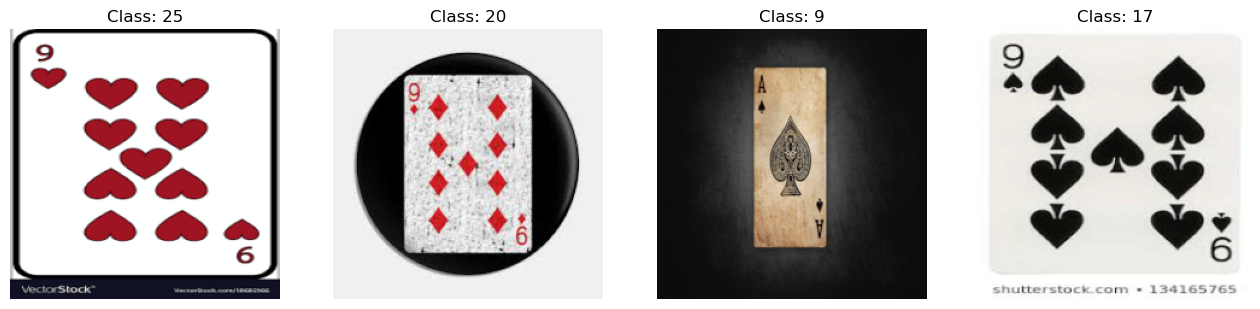

In [123]:
# Debug: visualizza un batch di immagini
def visualize_batch(data_loader):
    images, bboxes, labels = next(iter(data_loader))
    images = images[:4]  # Prendi le prime 4 immagini
    labels = labels[:4]  # Etichette corrispondenti

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).numpy()  # Cambia l'ordine dei canali per matplotlib
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalizza
        img = np.clip(img, 0, 1)  # Clip per evitare valori fuori intervallo
        axs[i].imshow(img)
        axs[i].set_title(f"Class: {label.item()}")
        axs[i].axis("off")
    plt.show()

visualize_batch(train_loader)


Visualizzazione delle predizioni per ResNet50:
Immagine: H710.jpg, Etichetta numerica: 0, Classe: seven of hearts
Immagine: C311.jpg, Etichetta numerica: 1, Classe: three of clubs
Immagine: s611.jpg, Etichetta numerica: 2, Classe: six of spades
Immagine: H811.jpg, Etichetta numerica: 3, Classe: eight of hearts
Immagine: ace-of-diamonds-vintage-playing-card-isolated-on-white-clipping-path-included-2AYKBH0.jpg, Etichetta numerica: 4, Classe: ace of diamonds
Immagine: H1012.png, Etichetta numerica: 5, Classe: ten of hearts
Immagine: king-spades-casino-card-game-P9N5YE.jpg, Etichetta numerica: 6, Classe: king of spades
Immagine: d213.png, Etichetta numerica: 7, Classe: two of diamonds
Immagine: 32199889600_2a7a32e987_b.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: H211.jpg, Etichetta numerica: 9, Classe: two of hearts
Immagine: download.jpeg, Etichetta numerica: 10, Classe: jack of spades
Immagine: C713.png, Etichetta numerica: 11, Classe: six of clubs
Immagine: C910.png, 

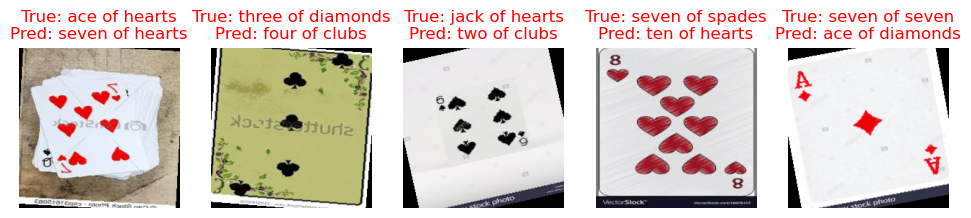

Visualizzazione delle predizioni per EfficientNet:
Immagine: H710.jpg, Etichetta numerica: 0, Classe: seven of hearts
Immagine: C311.jpg, Etichetta numerica: 1, Classe: three of clubs
Immagine: s611.jpg, Etichetta numerica: 2, Classe: six of spades
Immagine: H811.jpg, Etichetta numerica: 3, Classe: eight of hearts
Immagine: ace-of-diamonds-vintage-playing-card-isolated-on-white-clipping-path-included-2AYKBH0.jpg, Etichetta numerica: 4, Classe: ace of diamonds
Immagine: H1012.png, Etichetta numerica: 5, Classe: ten of hearts
Immagine: king-spades-casino-card-game-P9N5YE.jpg, Etichetta numerica: 6, Classe: king of spades
Immagine: d213.png, Etichetta numerica: 7, Classe: two of diamonds
Immagine: 32199889600_2a7a32e987_b.jpg, Etichetta numerica: 8, Classe: king of diamonds
Immagine: H211.jpg, Etichetta numerica: 9, Classe: two of hearts
Immagine: download.jpeg, Etichetta numerica: 10, Classe: jack of spades
Immagine: C713.png, Etichetta numerica: 11, Classe: six of clubs
Immagine: C910.p

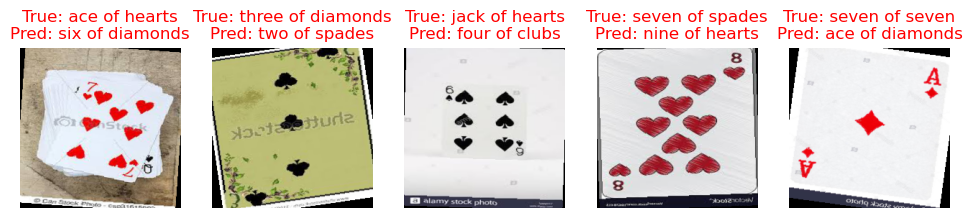

In [124]:
# Visualizza le predizioni per ResNet18
print("Visualizzazione delle predizioni per ResNet50:")
visualize_predictions(resnet_model, test_loader, train_idx_to_class, num_images=5)

print("Visualizzazione delle predizioni per EfficientNet:")
visualize_predictions(efficientnet_model, test_loader, train_idx_to_class, num_images=5)

